## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Елохов Артур Владимирович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
for X,y in train_dataset:
    print X.shape
    break

torch.Size([1, 28, 28])


In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

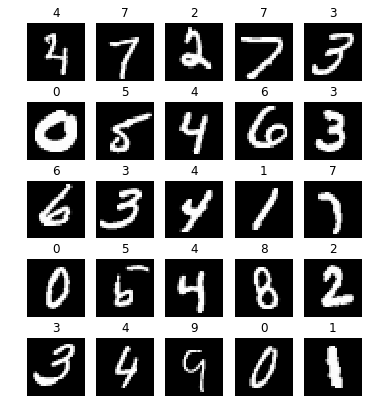

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

    
def init_layer_xavier(layer, n_i, n_i1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    border = (6.0/float(n_i + n_i1))**0.5
    weight.uniform_(-border, border)
    
def init_layer_he(layer, n_i):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=2.0/float(n_i))
    
def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    if grad_input[1] is not None:
        std = grad_input[1].std().data[0]
        print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
net = torch.nn.Sequential(torch.nn.Linear(784, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 10))

In [8]:
for layer in net:
    if('weight' in layer.state_dict()):
        init_layer(layer, 0.0, 0.1)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [9]:
##### YOUR CODE HERE #####

#пример:
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 10e-2
n_objects = 100
train_loader = DataLoader(train_dataset, batch_size=n_objects, shuffle=True)
for X, y in train_loader:
    X = Variable(X).view(n_objects, -1)
    y = Variable(y, requires_grad=False)
    L = []
    result = net(X)
    loss = loss_fn(result, y)
    net.zero_grad()
    loss.backward()
    for param in net.parameters():
        param.data -= learning_rate * param.grad.data
    
    break

forward 0.301143735647
forward 0.952827990055
forward 0.980920672417
forward 0.981116294861
forward 0.981564104557
forward 0.982216358185
forward 0.98219537735
forward 0.981432378292
forward 0.982035934925
forward 0.981724619865
forward 0.982281506062
forward 0.981489539146
backward 0.0132968304679
backward 0.0461000353098
backward 0.152607545257
backward 0.531944513321
backward 1.78748226166
backward 6.10222101212
backward 20.0813312531
backward 68.4170455933
backward 228.596252441
backward 773.848632812
backward 2661.38964844


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
net = torch.nn.Sequential(torch.nn.Linear(784, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 500),
                         torch.nn.Tanh(),
                         torch.nn.Linear(500, 10))

In [11]:
##### YOUR CODE HERE #####
###Xavier
last_layer = 22
sizes = [500] * 11
for idx, layer in enumerate(net):
    if('weight' in layer.state_dict()):
        if idx == last_layer:
            n_i = n_i1 = 10
        elif idx == last_layer - 2:
            n_i = 500
            n_i1 = 10
        else:
            n_i = n_i1 = 500
        init_layer_xavier(layer, n_i, n_i1)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=n_objects, shuffle=True)
for X, y in train_loader:
    X = Variable(X).view(n_objects, -1)
    y = Variable(y, requires_grad=False)
    L = []
    result = net(X)
    loss = loss_fn(result, y)
    net.zero_grad()
    loss.backward()
    for param in net.parameters():
        param.data -= learning_rate * param.grad.data
    break

forward 0.305071592331
forward 0.360704362392
forward 0.323095709085
forward 0.29060921073
forward 0.269361108541
forward 0.253074526787
forward 0.239549577236
forward 0.227396428585
forward 0.215272694826
forward 0.209102243185
forward 0.20493850112
forward 0.267936825752
backward 0.00340253370814
backward 0.00440144445747
backward 0.00420086272061
backward 0.00397914880887
backward 0.00376334786415
backward 0.00356809305958
backward 0.00342565192841
backward 0.00321793346666
backward 0.00303581985645
backward 0.0028005221393
backward 0.00258357170969


In [13]:
net = torch.nn.Sequential(torch.nn.Linear(784, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 500),
                         torch.nn.ReLU(),
                         torch.nn.Linear(500, 10))

In [14]:
###Xavier
last_layer = 22
sizes = [500] * 11
for idx, layer in enumerate(net):
    if('weight' in layer.state_dict()):
        if idx == last_layer:
            n_i = 10
        else:
            n_i = 500
        init_layer_he(layer, n_i)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=n_objects, shuffle=True)
for X, y in train_loader:
    X = Variable(X).view(n_objects, -1)
    y = Variable(y, requires_grad=False)
    L = []
    result = net(X)
    loss = loss_fn(result, y)
    net.zero_grad()
    loss.backward()
    for param in net.parameters():
        param.data -= learning_rate * param.grad.data
    break

forward 0.31010144949
forward 0.0216779224575
forward 0.00137976952828
forward 8.52917291922e-05
forward 5.62353443456e-06
forward 3.67936223711e-07
forward 2.24670149152e-08
forward 1.45130074625e-09
forward 9.35279215186e-11
forward 6.16363991096e-12
forward 4.06437849956e-13
forward 2.83033958683e-14
backward 0.00189508893527
backward 0.000125991820823
backward 7.87341559771e-06
backward 4.95199230954e-07
backward 3.13992281065e-08
backward 2.04098671297e-09
backward 1.27065122313e-10
backward 8.17385308743e-12
backward 5.23447984176e-13
backward 3.32342592574e-14
backward 2.1235960903e-15


<i> 1.4 Сделайте выводы по первой части </i>

Инициализация Xavier помогла поддержать постоянное значение дисперсии. Инициализация He практически занулила дисперсию.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [16]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        expanded_weight = torch.cat((self.weight, self.bias))
        ones = Variable(-torch.ones(x.data.shape[0] , 1), requires_grad=False)
        expanded_x = torch.cat((x, ones), 1)
        mask = torch.Tensor(expanded_weight.size())
        if(self.training):
            mask.bernoulli_(1 - self.p)
        else:
            mask.fill_(self.p)
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(expanded_x, torch.mul(expanded_weight, mask))
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [17]:
##### YOUR CODE HERE #####
class Model_dropout(nn.Module):
    def __init__(self):
        super(Model_dropout, self).__init__()
        self.model = nn.Sequential(nn.Linear(784, 200), 
                                     nn.Dropout(),
                                     nn.ReLU(),
                                     nn.Linear(200, 200),
                                     nn.Dropout(),
                                     nn.ReLU(),
                                     nn.Linear(200, 10))
    
    def forward(self, x):
        return self.model(x)
    

class Model_dropconnect(nn.Module):
    def __init__(self):
        super(Model_dropconnect, self).__init__()
        self.model = nn.Sequential(DropConnect(784, 200),
                                   nn.ReLU(),
                                   DropConnect(200, 200),
                                   nn.ReLU(),
                                   nn.Linear(200, 10))
    
    def forward(self, x):
        return self.model(x)

In [78]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [19]:
def apply_net(model, train, test, Epoch, learning_rate=0.01):
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    Loss_train = []
    Loss_test = []
    for epoch in xrange(Epoch):
        batch_losses_train = []
        batch_losses_test = []
        for X, y in train:
            X = Variable(X.view(X.size(0), -1))
            y = Variable(y.view(y.size(0), -1), requires_grad=False)
            result = model(X)
            loss = loss_fn(result, y.squeeze())
            batch_losses_train.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        for X, y in test:
            X = Variable(X.view(X.size(0), -1))
            y = Variable(y.view(y.size(0), -1), requires_grad=False)
            result = model(X)
            loss = loss_fn(result, y.squeeze())
            batch_losses_test.append(loss.data[0])
        Loss_train.append(sum(batch_losses_train)/len(batch_losses_train))
        Loss_test.append(sum(batch_losses_test)/len(batch_losses_test))
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    axis_y2 = np.array(Loss_test)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.plot(axis_x, axis_y2, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('NLL')
        plt.legend(['train', 'test'])
        plt.show()
    Scores = []
    model.eval()
    for X, y in test:
        X = Variable(X.view(X.size(0), -1))
        y = Variable(y.view(y.size(0), -1), requires_grad=False)
        result = model(X)
        Scores.append(accuracy_score(y.data.numpy(), np.argmax(result.data.numpy(), axis=1)))
    print("Accuracy: %f" %(sum(Scores)/len(Scores)))
    return

In [20]:
from sklearn.metrics import accuracy_score, mean_squared_error

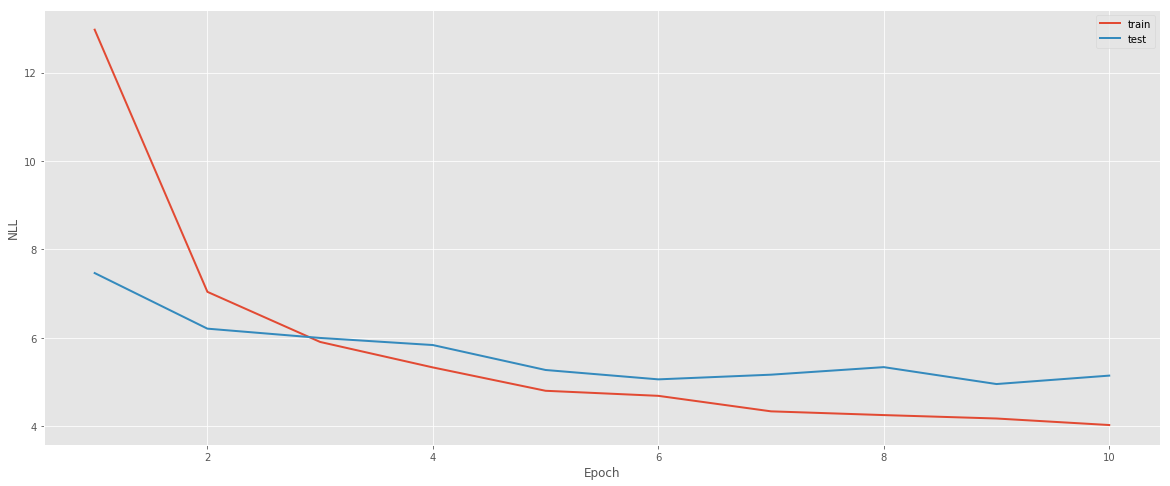

Accuracy: 0.976438


In [23]:
model = Model_dropout()
apply_net(model, train_loader, test_loader, Epoch=10, learning_rate=0.001)

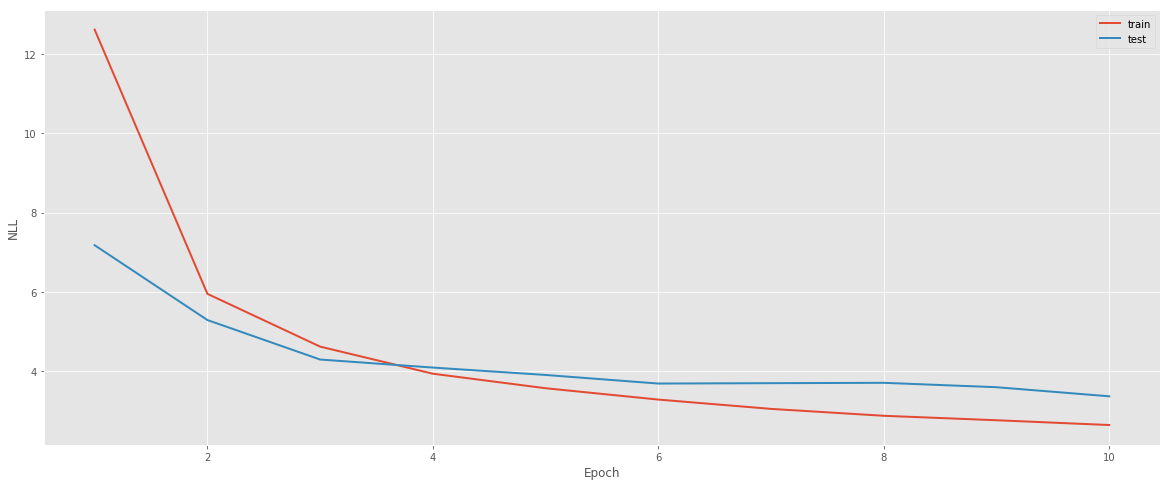

Accuracy: 0.978235


In [24]:
model = Model_dropconnect()
apply_net(model, train_loader, test_loader, Epoch=10, learning_rate=0.001)

<i> 2.3 Сделайте выводы по второй части </i>

В целом, Dropout и Dropconnect работают почти одинаково с точки зрения точности и скорости сходимости. Dropconnect немного лучше.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [75]:
t1 = Variable(torch.zeros(5, 4))
t2 = Variable(torch.Tensor(1, 4).normal_())
print t2
print t2.expand(2,4)

Variable containing:
 0.6271 -0.2275 -0.4893  0.7469
[torch.FloatTensor of size 1x4]

Variable containing:
 0.6271 -0.2275 -0.4893  0.7469
 0.6271 -0.2275 -0.4893  0.7469
[torch.FloatTensor of size 2x4]



In [137]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)
class LayerNormalization(nn.Module):
    def __init__(self, num_features, alpha=0.1):
        super(LayerNormalization, self).__init__()
        self.alpha = alpha
        #не совсем понятно, как именно считать среднее, т.е. по каким размерностям
        self.mean = Variable(torch.zeros(1), requires_grad=False)
        self.std = Variable(torch.ones(1), requires_grad=False)
        self.gamma = nn.Parameter(torch.Tensor(1, num_features).normal_())
        self.beta = nn.Parameter(torch.Tensor(1, num_features).normal_())
    
    def forward(self, x):
        eps = 1e-10
        x_size = x.size()
        self.mean = (1.0 - self.alpha) * self.mean + self.alpha * x.mean()
        self.std = (1.0 - self.alpha) * self.std + self.alpha * x.std()
        if(self.training):
            x_mean = x.mean(dim=1, keepdim=True)
            x_std = x.std(dim=1, keepdim=True)
            x_norm = (x - x_mean) / (x_std + eps)
        else:
            x_norm = (x - self.mean.expand(x_size)) / (self.std.expand(x_size) + eps)
            ###при подсчете среднего тем же способом, что на трейне, результат получался немного лучше
            ###x_norm = (x - x_mean) / (x_std + eps)
        output = self.gamma.expand(x_size) * x_norm  - self.beta.expand(x_size)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [138]:
##### YOUR CODE HERE #####
class Model_batch_norm(nn.Module):
    def __init__(self):
        super(Model_batch_norm, self).__init__()
        self.model = nn.Sequential(nn.Linear(784, 200),
                                   torch.nn.BatchNorm1d(200),
                                   nn.ReLU(),
                                   nn.Linear(200, 200),
                                   torch.nn.BatchNorm1d(200),
                                   nn.ReLU(),
                                   nn.Linear(200, 10))
    
    def forward(self, x):
        return self.model(x)
    
class Model_layer_norm(nn.Module):
    def __init__(self):
        super(Model_layer_norm, self).__init__()
        self.model = nn.Sequential(nn.Linear(784, 200),
                                   LayerNormalization(200),
                                   nn.ReLU(),
                                   nn.Linear(200, 200),
                                   LayerNormalization(200),
                                   nn.ReLU(),
                                   nn.Linear(200, 10))
    
    def forward(self, x):
        return self.model(x)

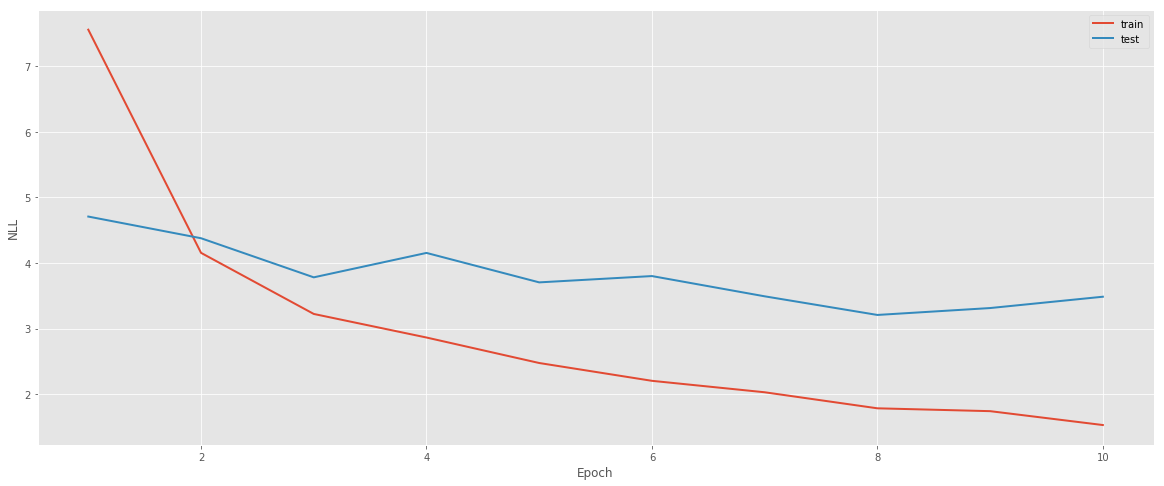

Accuracy: 0.977935


In [139]:
model = Model_batch_norm()
apply_net(model, train_loader, test_loader, Epoch=10, learning_rate=0.01)

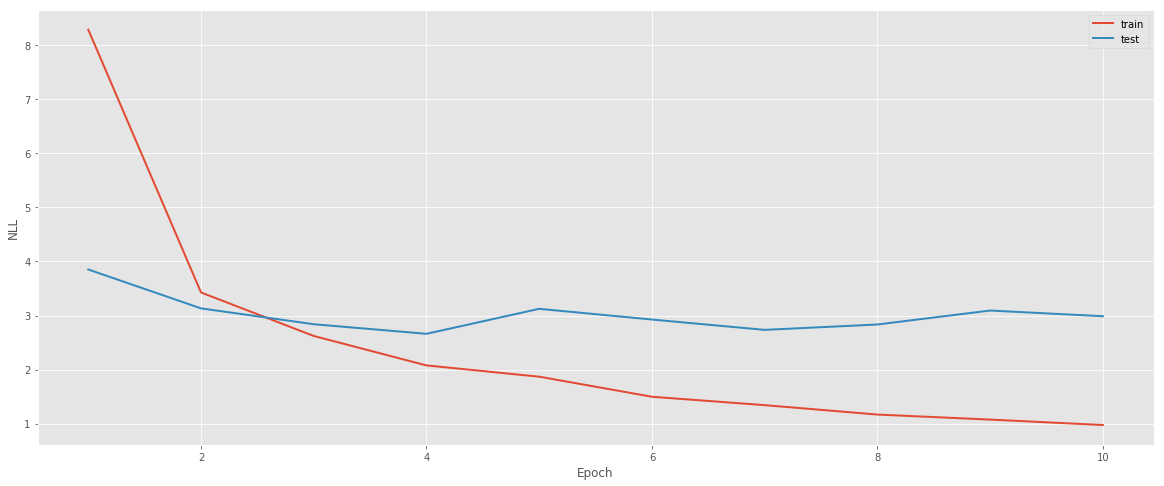

Accuracy: 0.974141


In [140]:
model = Model_layer_norm()
apply_net(model, train_loader, test_loader, Epoch=10, learning_rate=0.01)

<i> 3.3 Сделайте выводы по третьей части </i>

У layer normalization немного лучше скорость сходимости, но немного хуже точность.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: